<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/master/feature_eval/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#!pip install gdown

In [19]:
folder_name = '../../runs/Feb09_19-30-54_frank-lab2/'

# !gdown https://drive.google.com/uc?id=1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk # ResNet 18 --> 40 epochs trained
# !gdown https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT # ResNet 18 --> 80 epochs trained
# !unzip resnet-18_80-epochs
# !ls

In [20]:
!ls

linear_feature_eval_galaxy.ipynb		resnet-18_80-epochs.zip
linear_feature_eval.ipynb			stl10_binary
mini_batch_logistic_regression_evaluator.ipynb	stl10_binary.tar.gz
resnet-18_80-epochs				stl10_binary.tar.gz.1


In [21]:
# download and extract stl10
# !wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
# !tar -zxvf stl10_binary.tar.gz
# !ls

In [28]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from data_aug.gaussian_blur import GaussianBlur
from torchvision import datasets

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [30]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/joshua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 512,
 'epochs': 80,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [31]:
checkpoints_folder

'../../runs/Feb09_19-30-54_frank-lab2/checkpoints'

In [32]:

## Custom Galaxy Zoo Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label


In [47]:
# load STL-10 train data
import pandas as pd
import os, sys
from PIL import Image
X_train = GalaxyZooDataset('/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv', '/media/joshua/Milano/galaxy_zoo/train/')

print("train info", len(X_train), X_train[0][1])

sample_image = np.asarray(X_train[0][0])

print("sample image shape", sample_image.shape)



train info 46183 4
sample image shape (424, 424, 3)


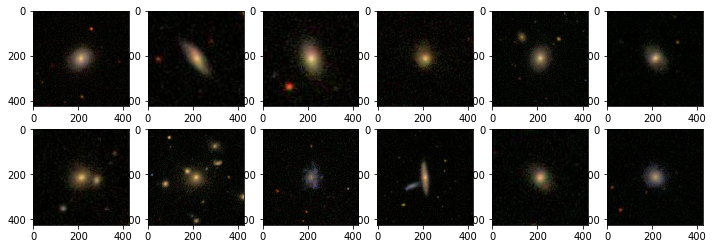

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    sample_image = np.asarray(X_train[i][0])
    ax.imshow(sample_image)
plt.show()

In [ ]:
# load STL-10 test data
# X_test, y_test = _load_stl10("test")

## Test protocol #1 PCA features

In [50]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

AttributeError: 'GalaxyZooDataset' object has no attribute 'reshape'

In [ ]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [ ]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

## Protocol #2 Logisitc Regression

In [51]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [52]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [53]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [61]:
X_train[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=424x424 at 0x7F417A716190>,
 4)

In [55]:
X_train_feature = []



for batch_x, batch_y in next_batch(X_train[:][0], X_train[:][1], batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

TypeError: join() argument must be str or bytes, not 'Series'

In [ ]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

In [ ]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

In [ ]:
### plotting features and 

for i in range(10):
    
    if y_train[i] == 1 or y_train[i] == 5:
        plt.imshow(X_train[i].transpose(1,2,0))
        plt.title(y_train[i])
        plt.show()

        

        plt.plot(np.log(X_train_feature[i]), '.')
        plt.title("representation")
        plt.show()
        
    

# fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

# for i, ax in enumerate(axs.flat):
#   ax.imshow(X_train[i].transpose(1,2,0))
# plt.show()

In [ ]:
import umap


embedding = umap.UMAP().fit_transform(X_train_feature)
"umapembed=pd.DataFrame({'labels':labels,'umap0':embedding[:,0],'umap1':embedding[:,1]})\n",
"# sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels,\n",
"#                 hue_order=['-0.94', '-0.5', '0', '0.5', '0.94'],\n",
"#                 linewidth=0,s=1,palette='viridis', legend='full')\n",
"sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels,\n",
"                linewidth=0,s=3,palette='viridis', legend='full')\n",
"plt.legend(bbox_to_anchor=(0.98, 1))\n",
"plt.show()"

In [ ]:
import pandas as pd
import seaborn as sns
umapembed=pd.DataFrame({'labels':y_train,'umap0':embedding[:,0],'umap1':embedding[:,1]})
# sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels, hue_order=['-0.94', '-0.5', '0', '0.5', '0.94'],
# linewidth=0,s=1,palette='viridis', legend='full')
sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=y_train, linewidth=0,s=3,palette='viridis', legend='full')
plt.legend(bbox_to_anchor=(0.98, 1))
plt.show()